## Summary notes

This **#TidyTuesday** project was posted back on 14th May, 2018.
Here's the motivating tweet from [@thomas_mock](https://twitter.com/thomas_mock):

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">The <a href="https://twitter.com/R4DScommunity?ref_src=twsrc%5Etfw">@R4DScommunity</a> welcomes you to week 7 of <a href="https://twitter.com/hashtag/TidyTuesday?src=hash&amp;ref_src=twsrc%5Etfw">#TidyTuesday</a> !<br><br>We&#39;ll explore survey data of the original 6 Star Wars movies! <br><br>Survey Data: <a href="https://t.co/sElb4fcv3u">https://t.co/sElb4fcv3u</a><br>Article: <a href="https://t.co/wvrilKiudh">https://t.co/wvrilKiudh</a><br>Character Data: <a href="https://t.co/h8xgscXH1Z">https://t.co/h8xgscXH1Z</a><a href="https://twitter.com/hashtag/rstats?src=hash&amp;ref_src=twsrc%5Etfw">#rstats</a> <a href="https://twitter.com/hashtag/tidyverse?src=hash&amp;ref_src=twsrc%5Etfw">#tidyverse</a> <a href="https://twitter.com/hashtag/r4ds?src=hash&amp;ref_src=twsrc%5Etfw">#r4ds</a> <a href="https://twitter.com/hashtag/dataviz?src=hash&amp;ref_src=twsrc%5Etfw">#dataviz</a> <a href="https://t.co/lS1QRoropO">pic.twitter.com/lS1QRoropO</a></p>&mdash; Tom Mock (@thomas_mock) <a href="https://twitter.com/thomas_mock/status/996020903363399680?ref_src=twsrc%5Etfw">May 14, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

## Constants

In [3]:
STARWARS_URL = ('https://raw.githubusercontent.com/rfordatascience/'
                + 'tidytuesday/master/data/2018/2018-05-14/'
                + 'week7_starwars.csv')

In [4]:
#| code-summary: 'Map of columns labels, keys = (episode, characters)'
COLUMNS = {
    'episodes': ['a_phantom_menace',
                 'attack_of_the_clones',
                 'revenge_of_the_sith',
                 'a_new_hope',
                 'the_empire_strikes_back',
                 'return_of_the_jedi'],
    'characters': ['han_solo',
                   'luke_skywalker',
                   'princess_leia_organa',
                   'anakin_skywalker',
                   'obi_wan_kenobi',
                   'emperor_palpatine',
                   'darth_vader',
                   'lando_calrissian',
                   'boba_fett',
                   'c-3p0',
                   'r2_d2',
                   'jar_jar_binks',
                   'padme_amidala',
                   'yoda']
}

In [5]:
#| code-summary: 'Map of CategoricalDtypes'
CATEGORIES = {
    'episode': CategoricalDtype(
            COLUMNS['episodes'], ordered=True
    ), 'gender': CategoricalDtype(
            ['Male',
             'Female',
             'No response']
    ), 'age': CategoricalDtype(
            ['18-29',
             '30-44',
             '45-60',
             '> 60',
             'No response'],
            ordered=True
    ), 'household_income': CategoricalDtype(
            ['0 - 24,999',
             '25,000 - 49,999',
             '50,000 - 99,999',
             '100,000 - 149,999',
             '150,000+',
             'No response'],
            ordered=True
    ), 'education': CategoricalDtype(
            ['Less than high school degree',
             'High school degree',
             'Some college or Associate degree',
             'Bachelor degree',
             'Graduate degree',
             'No response'],
            ordered=True
    ), 'episode_rank': CategoricalDtype(
            [str(n) for n in range(1, 7)] + ['No response'],
            ordered=True
    )
}

## Functions

In [6]:
def set_idx_cols(sw: pd.DataFrame, columns: dict[list]) -> pd.DataFrame:
    """Return a view of sw with new index and multiindex columns.
    Source dataframe is not mutated.

    Preconditions:
    - ('episodes', 'characters') in keys(columns)
    - sw.shape = (1136, 38,)
    - sw ordering has not been altered post-import

    Postconditions:
    - nsw.shape = (1136. 37,)
    - nsw.index is sw['RespondentID']
    - 'RespondentID' not in nsw.columns
    - nsw has multiindex columns
        - Level 0 represents the question group or topic
        - Level 1 represents the target of the question or topic
        - See Summary Notes: Schema for the structure
    """
    nsw = sw.set_index(starwars.columns[0]).rename_axis('id', axis=0)
    cs = np.empty(shape=(2, 37), dtype='object')
    cs[0, :] = (['other', 'fan']
                + ['episode_seen'] * 6
                + ['episode_rank'] * 6
                + ['char_view'] * 14
                + ['other'] * 2
                + ['fan'] * 2
                + ['demographic'] * 5)
    cs[1, :] = (['has_seen_star_wars']
                + ['star_wars']
                + columns['episodes'] * 2
                + columns['characters']
                + ['who_shot_first']
                + ['is_familiar_expanded_universe']
                + ['expanded_universe']
                + ['star_trek']
                + ['gender']
                + ['age']
                + ['household_income']
                + ['education']
                + ['location'])
    return nsw.set_axis(pd.MultiIndex.from_arrays(cs), axis=1)


In [7]:
def categorise_all(s: pd.Series, ctypes: dict = {}) -> pd.Series:
    if s.name in ctypes:
        return s.astype(ctypes[s.name])
    return s.astype(CategoricalDtype(np.unique(s), ordered=False))

In [8]:
def categorise(s: pd.Series, ctypes: dict = {}) -> pd.Series:
    if s.name in ctypes:
        return s.astype(ctypes[s.name])
    return s

In [9]:
def pct(s, dp: int = 1) -> pd.Series:
    return s.div(s.sum()).mul(100).round(dp)

In [10]:
def group_pct(s, group: str = '', dp: int = 1) -> pd.Series:
    return s.div(s.groupby(level=group).sum()).mul(100).round(dp)

## Main

### Load the data

In [11]:
starwars = pd.read_csv(STARWARS_URL, encoding='cp1252', header=[0, 1])
starwars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 38 columns):
 #   Column                                                                                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                                                                                     --------------  -----  
 0   (RespondentID, Unnamed: 0_level_1)                                                                                                                                                         1186 non-null   int64  
 1   (Have you seen any of the 6 films in the Star Wars franchise?, Response)                                                                                                                   1186 non-null   object 
 2   (Do you consider yoursel

### Process the data

In [12]:
#| code-summary: 'Clean the source data'
v_starwars = set_idx_cols(starwars, COLUMNS)
v_starwars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 3292879998 to 3288372923
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   (other, has_seen_star_wars)              1186 non-null   object 
 1   (fan, star_wars)                         836 non-null    object 
 2   (episode_seen, a_phantom_menace)         673 non-null    object 
 3   (episode_seen, attack_of_the_clones)     571 non-null    object 
 4   (episode_seen, revenge_of_the_sith)      550 non-null    object 
 5   (episode_seen, a_new_hope)               607 non-null    object 
 6   (episode_seen, the_empire_strikes_back)  758 non-null    object 
 7   (episode_seen, return_of_the_jedi)       738 non-null    object 
 8   (episode_rank, a_phantom_menace)         835 non-null    float64
 9   (episode_rank, attack_of_the_clones)     836 non-null    float64
 10  (episode_rank, revenge_of_the_sit

In [13]:
#| code-summary ''
demographic = (
    v_starwars
    .get('demographic')
    .fillna('No response')
    .applymap(lambda x: x.replace('$', ''))
    .transform(categorise_all, ctypes=CATEGORIES)
)
demographic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 3292879998 to 3288372923
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            1186 non-null   category
 1   age               1186 non-null   category
 2   household_income  1186 non-null   category
 3   education         1186 non-null   category
 4   location          1186 non-null   category
dtypes: category(5)
memory usage: 16.2 KB


In [14]:
#| code-summary: 'Clean the episode_rank table'
episode_rank = (
    v_starwars
    .get('episode_rank')
    .fillna('No response')
    .applymap(lambda x: str(int(x)) if x != 'No response' else x)
    .transform(lambda s: s.astype(CATEGORIES['episode_rank']))
)
episode_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 3292879998 to 3288372923
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   a_phantom_menace         1186 non-null   category
 1   attack_of_the_clones     1186 non-null   category
 2   revenge_of_the_sith      1186 non-null   category
 3   a_new_hope               1186 non-null   category
 4   the_empire_strikes_back  1186 non-null   category
 5   return_of_the_jedi       1186 non-null   category
dtypes: category(6)
memory usage: 18.3 KB


### Visualise the data

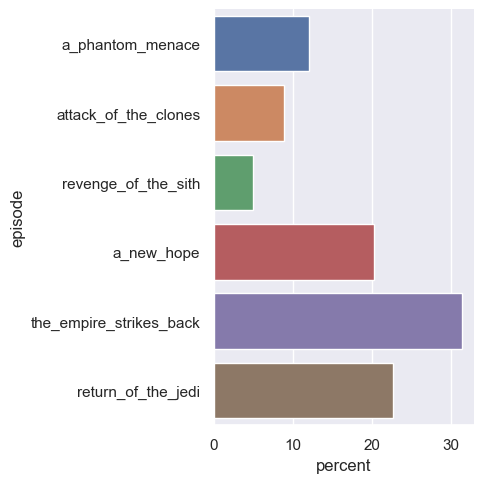

In [20]:
#| code-summary: 'What is the best Star Wars film?'
gsource = (
    episode_rank
    .melt(var_name='episode', value_name='rank')
    .query("rank in ['1', '2']")
    .groupby('episode').size()
    .transform(pct)
    .rename('percent')
    .to_frame().reset_index()
    .transform(categorise, ctypes=CATEGORIES)
)
g = sns.catplot(data=gsource, x='percent', y='episode', kind='bar')
plt.show()

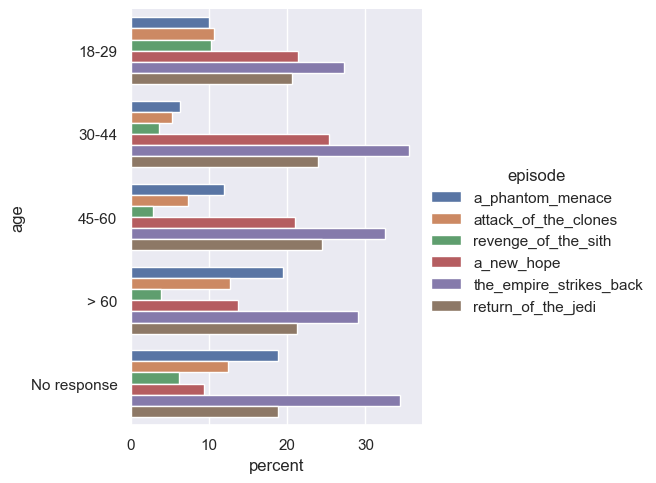

In [16]:
#| code-summary: 'What is the best Star Wars film by age?'
gsource = (
    episode_rank
    .merge(demographic, left_index=True, right_index=True)
    .melt(
        id_vars='age',
        var_name='episode',
        value_name='rank',
        ignore_index=False
    ).query("rank in ['1', '2']")
    .groupby(['age', 'episode']).size()
    .transform(group_pct, group='age')
    .rename('percent')
    .to_frame().reset_index()
    .transform(categorise, ctypes=CATEGORIES)
)
g = sns.catplot(data=gsource, x='percent', y='age', hue='episode', kind='bar')

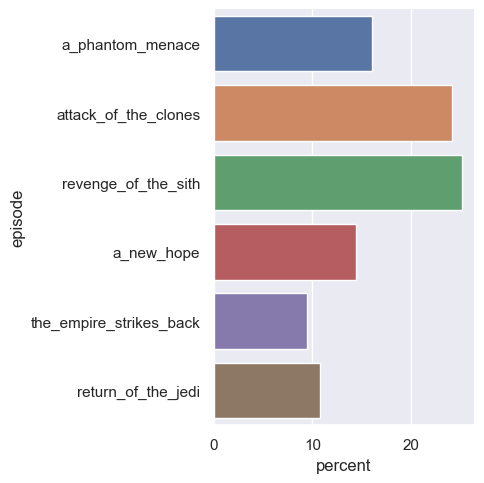

In [17]:
#| code-summary: 'What is the worst Star Wars film?'
gsource = (
    episode_rank
    .melt(var_name='episode', value_name='rank')
    .query("rank in ['5', '6']")
    .groupby('episode')
    .size()
    .transform(pct)
    .rename('percent')
    .to_frame().reset_index()
    .transform(categorise, ctypes=CATEGORIES)
)
g = sns.catplot(data=gsource, x='percent', y='episode', kind='bar')

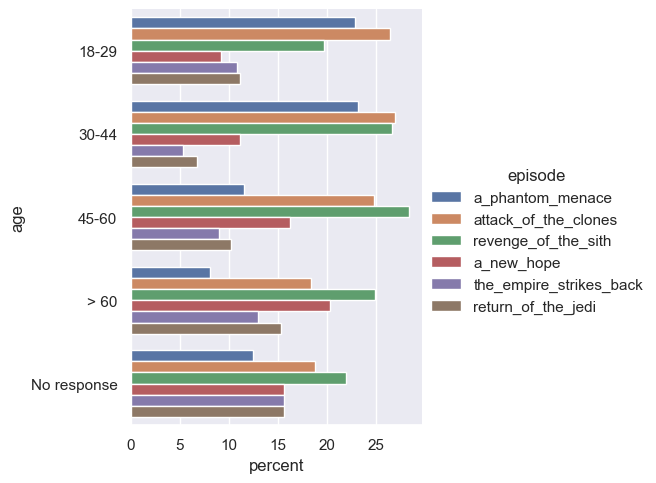

In [19]:
#| code-summary: 'What is the worst Star Wars film by age?'
gsource = (
    episode_rank
    .merge(demographic, left_index=True, right_index=True)
    .melt(
        id_vars='age',
        var_name='episode',
        value_name='rank',
        ignore_index=False
    ).query("rank in ['5', '6']")
    .groupby(['age', 'episode']).size()
    .transform(group_pct, group='age')
    .rename('percent')
    .to_frame().reset_index()
    .transform(categorise, ctypes=CATEGORIES)
)
gsource
g = sns.catplot(data=gsource, x='percent', y='age', hue='episode', kind='bar')